In [1]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import joblib

In [ ]:
import tensorflow as tf
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, InputLayer, Bidirectional, LSTM
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from keras.callbacks import ModelCheckpoint, TensorBoard

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier, SklearnClassifier, KerasClassifier
from art.estimators.classification.scikitlearn import ScikitlearnSVC, ScikitlearnClassifier
from tensorflow.keras.models import load_model, Model
from art.attacks.evasion import ProjectedGradientDescentTensorFlowV2, FastGradientMethod, BasicIterativeMethod, CarliniL2Method, ZooAttack, SquareAttack, DeepFool, ProjectedGradientDescent
from art.utils import load_dataset

In [ ]:
# Set the dataset directory
DATASET_DIRECTORY = '/content/drive/MyDrive/research_paper/dataset/'

# Importing Dataset
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Create a Dask DataFrame
df_dataframes = [pd.read_csv(DATASET_DIRECTORY + train_set) for train_set in df_sets]

# Concatenate all Dask DataFrames into a single Dask DataFrame
rf_df = pd.concat(df_dataframes, axis=0)

# Compute summary statistics
summary_stats = rf_df.describe()

In [ ]:
summary_stats.T

,count,mean,std,min,25%,50%,75%,max
2344.615911050957,44999.0,2399.942852,47.933054,2195.022327,2367.694958,2399.863764,2432.204942,2613.413440
1.9574423265130767,44999.0,-0.003795,3.001863,-11.867836,-2.033317,-0.006213,2.028796,11.793667
-11.051929465903774,44999.0,0.136230,10.018179,-38.752193,-6.623464,0.163819,6.901243,37.783141
2423.5117862712,44999.0,2400.136396,48.124777,2210.757977,2367.975170,2399.999410,2432.795490,2586.817655
-2.2754797717917516,44999.0,0.008793,2.999632,-12.069000,-2.012268,0.011625,2.040403,13.740709
-8.528997952577445,44999.0,-0.080621,10.006488,-45.609895,-6.835284,-0.031722,6.662069,41.707004
2341.1017246483125,44999.0,2400.274438,47.814745,2210.082729,2368.184517,2400.086062,2432.482341,2604.359828
2.5952265267603414,44999.0,-0.015069,2.998891,-13.127872,-2.051254,-0.018837,2.012735,11.858345
-14.023894303097165,44999.0,0.025594,9.976182,-40.297279,-6.737246,0.026324,6.770981,45.136262
2366.446146425568,44999.0,2399.578947,47.879663,2206.149462,2367.174654,2399.640220,2431.407890,2602.887251


In [ ]:
rf_df.head()

,2344.615911050957,1.9574423265130767,-11.051929465903774,2423.5117862712,-2.2754797717917516,-8.528997952577445,2341.1017246483125,2.5952265267603414,-14.023894303097165,2366.446146425568,-1.095272677252039,10.161423421785784,2431.767896332381,2.8676329205273694,-22.067483064529085
0,2370.816359,-2.094190,0.889730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2417.816902,0.694941,6.865081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2321.900235,0.581671,-3.735895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2422.535924,-4.027744,2.180007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2427.754466,0.869333,8.330654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rf_df.shape

(224995, 15)

In [ ]:
rf_df.isnull().sum()

,0
2344.615911050957,179996
1.9574423265130767,179996
-11.051929465903774,179996
2423.5117862712,179996
-2.2754797717917516,179996
-8.528997952577445,179996
2341.1017246483125,179996
2.5952265267603414,179996
-14.023894303097165,179996
2366.446146425568,179996


In [ ]:
df = rf_df.fillna(rf_df.mean())

In [ ]:
df.head()

,2344.615911050957,1.9574423265130767,-11.051929465903774,2423.5117862712,-2.2754797717917516,-8.528997952577445,2341.1017246483125,2.5952265267603414,-14.023894303097165,2366.446146425568,-1.095272677252039,10.161423421785784,2431.767896332381,2.8676329205273694,-22.067483064529085
0,2370.816359,-2.094190,0.889730,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583
1,2417.816902,0.694941,6.865081,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583
2,2321.900235,0.581671,-3.735895,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583
3,2422.535924,-4.027744,2.180007,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583
4,2427.754466,0.869333,8.330654,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583


In [ ]:
# Preprocess data
scaler = StandardScaler()
rf_fingerprints_scaled = scaler.fit_transform(df)

In [ ]:
# Use K-Means clustering to generate pseudo-labels (0 and 1)
kmeans = KMeans(n_clusters=2, random_state=42)
pseudo_labels = kmeans.fit_predict(rf_fingerprints_scaled)

In [ ]:
# Count occurrences of each unique value
unique, counts = np.unique(pseudo_labels, return_counts=True)

# Print the results
for value, count in zip(unique, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 196699
Value: 1, Count: 28296


In [ ]:
df['label'] = pseudo_labels

In [ ]:
df.head()

,2344.615911050957,1.9574423265130767,-11.051929465903774,2423.5117862712,-2.2754797717917516,-8.528997952577445,2341.1017246483125,2.5952265267603414,-14.023894303097165,2366.446146425568,-1.095272677252039,10.161423421785784,2431.767896332381,2.8676329205273694,-22.067483064529085,label
0,2370.816359,-2.094190,0.889730,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583,0
1,2417.816902,0.694941,6.865081,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583,0
2,2321.900235,0.581671,-3.735895,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583,0
3,2422.535924,-4.027744,2.180007,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583,0
4,2427.754466,0.869333,8.330654,2400.136396,0.008793,-0.080621,2400.274438,-0.015069,0.025594,2399.578947,-0.00968,-0.032099,2399.969898,0.00358,0.075583,0


In [ ]:
df.to_csv('/content/drive/MyDrive/adversarial_paper/dataset.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/adversarial_paper/dataset.csv')

In [ ]:
X, y = df.drop('label', axis=1), df['label']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [ ]:
x_train.shape

(179996, 15)

In [ ]:
x_test.shape

(44999, 15)

In [ ]:
y_train.shape

(179996,)

In [ ]:
y_test.shape

(44999,)

### 1. TARGET CNN MODEL

In [ ]:
# Define CNN model
cnn = Sequential()
cnn.add(InputLayer(shape=(x_train.shape[1], 1)))
cnn.add(Conv1D(32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_history = cnn.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val)).history

Epoch 1/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8104 - loss: 6.9636 - val_accuracy: 0.9495 - val_loss: 0.1850
Epoch 2/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9217 - loss: 0.5022 - val_accuracy: 0.9623 - val_loss: 0.1009
Epoch 3/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9386 - loss: 0.2286 - val_accuracy: 0.9561 - val_loss: 0.1167
Epoch 4/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9474 - loss: 0.1411 - val_accuracy: 0.9422 - val_loss: 0.1373
Epoch 5/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9497 - loss: 0.1340 - val_accuracy: 0.9709 - val_loss: 0.0896
Epoch 6/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9595 - loss: 0.1032 - val_accuracy: 0.9756 - val_loss: 0.0622
Epoch 7/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9625 - loss: 0.0944 - val_accuracy: 0.9705 - val_loss: 0.0791
Epoch 8/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9647 - loss: 0

In [ ]:
cnn.save('/content/drive/MyDrive/adversarial_paper/Models/cnn_model.keras')

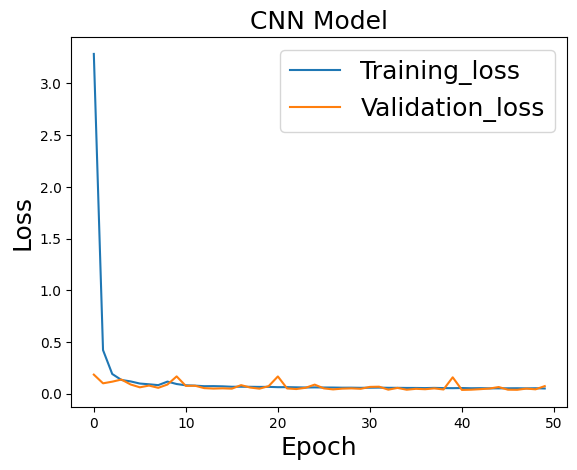

In [ ]:
plt.plot(cnn_history['loss'])
plt.plot(cnn_history['val_loss'])
plt.title('CNN Model', fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.legend(['Training_loss', 'Validation_loss'], loc='upper right',fontsize=18)
#plt.savefig('/content/drive/MyDrive/adversarial_paper/Results/target_loss.pdf', bbox_inches='tight',dpi=600)
plt.show()

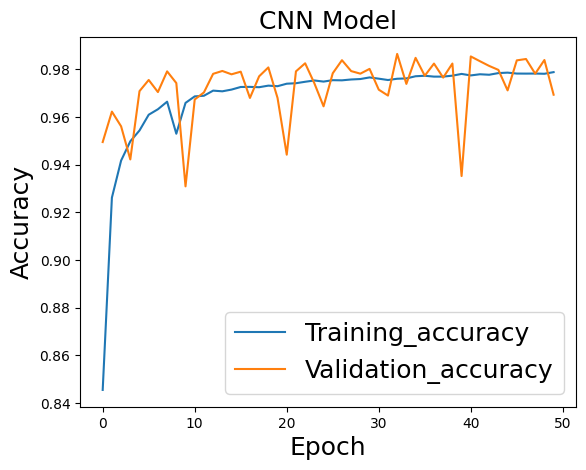

In [ ]:
plt.plot(cnn_history['accuracy'])
plt.plot(cnn_history['val_accuracy'])
plt.title('CNN Model', fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.legend(['Training_accuracy', 'Validation_accuracy'], loc='lower right',fontsize=18)
#plt.savefig('/content/drive/MyDrive/adversarial_paper/Results/target_accuracy.pdf', bbox_inches='tight',dpi=600)
plt.show()

In [ ]:
# evaluate the model
y_pred = cnn.predict(x_test)
y_pred = np.round(y_pred).flatten()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

3938/3938 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Accuracy: 0.9710
Precision: 0.8153
Recall: 0.9944
F1 Score: 0.8960


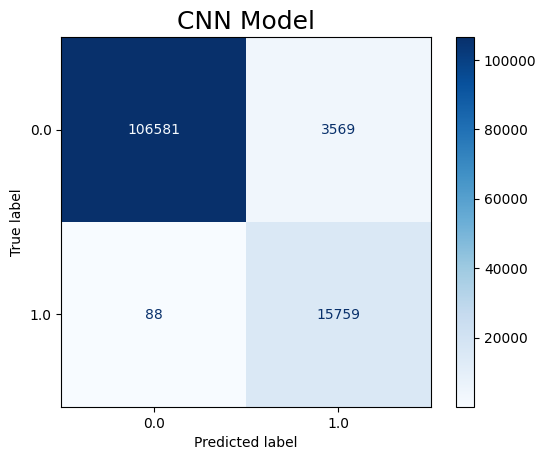

In [ ]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(np.concatenate((y_test, y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('CNN Model', fontsize=18)
plt.show()

In [ ]:
cnn.summary()

In [ ]:
cnn_model= load_model('/content/drive/MyDrive/adversarial_paper/Models/cnn_model.keras')

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Create TensorFlowV2Classifier instance
cnn_classifier = TensorFlowV2Classifier(
    model=cnn_model,
    nb_classes=2,
    input_shape=15,
    clip_values=(np.min(x_train), np.max(x_train)),
    loss_object=loss_object
)

### 2. SURROGATE NN MODEL

In [ ]:
nn = Sequential()
nn.add(InputLayer(shape=(x_train.shape[1],)))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
nn_history = nn.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val)).history

Epoch 1/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8656 - loss: 1.9960 - val_accuracy: 0.9340 - val_loss: 0.2235
Epoch 2/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9322 - loss: 0.4239 - val_accuracy: 0.9684 - val_loss: 0.1134
Epoch 3/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9423 - loss: 0.2595 - val_accuracy: 0.9510 - val_loss: 0.2202
Epoch 4/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9482 - loss: 0.1881 - val_accuracy: 0.9697 - val_loss: 0.0809
Epoch 5/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9522 - loss: 0.1373 - val_accuracy: 0.9648 - val_loss: 0.0927
Epoch 6/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9538 - loss: 0.1247 - val_accuracy: 0.9581 - val_loss: 0.1111
Epoch 7/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9579 - loss: 0.1161 - val_accuracy: 0.9662 - val_loss: 0.0860
Epoch 8/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9601 - loss: 0

In [ ]:
nn.save('/content/drive/MyDrive/adversarial_paper/Models/nn_model.keras')

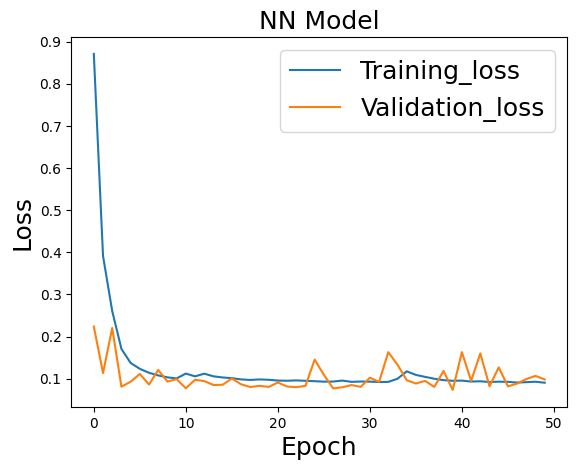

In [ ]:
plt.plot(nn_history['loss'])
plt.plot(nn_history['val_loss'])
plt.title('NN Model', fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.legend(['Training_loss', 'Validation_loss'], loc='upper right',fontsize=18)
plt.show()

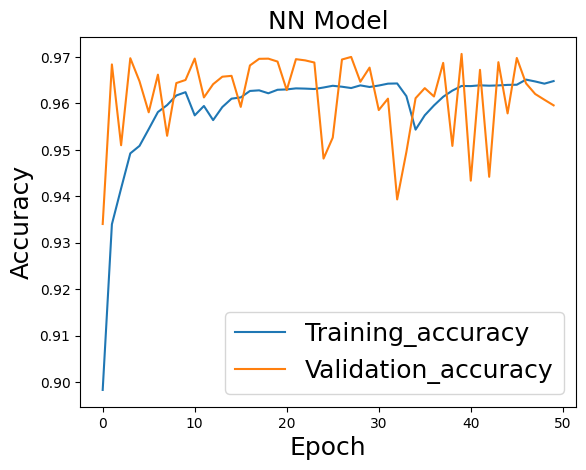

In [ ]:
plt.plot(nn_history['accuracy'])
plt.plot(nn_history['val_accuracy'])
plt.title('NN Model', fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.legend(['Training_accuracy', 'Validation_accuracy'], loc='lower right',fontsize=18)
plt.show()

In [ ]:
y_pred_nn = nn.predict(x_test)
y_pred_nn = np.round(y_pred_nn).flatten()
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print(f'Accuracy: {accuracy_nn:.4f}')
print(f'Precision: {precision_nn:.4f}')
print(f'Recall: {recall_nn:.4f}')
print(f'F1 Score: {f1_nn:.4f}')

3938/3938 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Accuracy: 0.9577
Precision: 0.9865
Recall: 0.6733
F1 Score: 0.8003


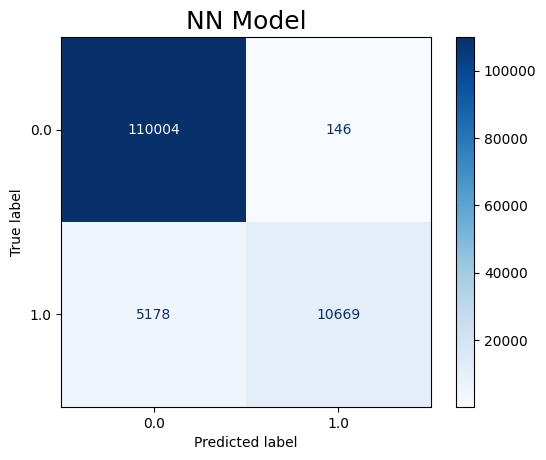

In [ ]:
cm_nn = confusion_matrix(y_test, y_pred_nn)
labels_nn = np.unique(np.concatenate((y_test, y_pred_nn)))
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=labels_nn)
disp_nn.plot(cmap=plt.cm.Blues)
plt.title('NN Model', fontsize=18)
plt.show()

In [ ]:
nn_model= load_model('/content/drive/MyDrive/adversarial_paper/Models/nn_model.keras')

In [ ]:
nn_classifier = TensorFlowV2Classifier(
    model=nn_model,
    nb_classes=2,
    input_shape=15,
    clip_values=(np.min(x_train), np.max(x_train)),
    loss_object=loss_object
)

In [ ]:
epsilons = [1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]

In [ ]:
x_train_reshaped = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test_reshaped = x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1)

### UNTARGETED PGD ATTACK ON CNN MODEL

In [ ]:
# Projected Gradient Descent (PGD)
for epsilon in epsilons:
  pgd_attack = ProjectedGradientDescentTensorFlowV2(
      nn_classifier,
      eps=epsilon,  # Maximum perturbation
      eps_step=100,  # Step size
      max_iter=10,  # Number of iterations
      num_random_init=True,
      targeted=False, # Untargeted attack
      batch_size=128
      )
  x_test_adv_pgd = pgd_attack.generate(x_test_reshaped)

  # Black-box PGD
  y_pred_adv_pgd_target = cnn_classifier.predict(x_test_adv_pgd)
  y_pred_adv_pgd_target = np.round(y_pred_adv_pgd_target).flatten()
  print("Black-box PGD Attack:")
  print("Epsilon:", {epsilon})
  print(f"Accuracy: {accuracy_score(y_test, y_pred_adv_pgd_target):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred_adv_pgd_target, average='weighted', zero_division=1):.4f}")
  print(f"Recall: {recall_score(y_test, y_pred_adv_pgd_target, average='weighted', zero_division=1):.4f}")
  print(f"F1 Score: {f1_score(y_test, y_pred_adv_pgd_target, average='weighted', zero_division=1):.4f}")
  print()

  # White-box PGD
  y_pred_adv_pgd_whitebox = nn_classifier.predict(x_test_adv_pgd)
  y_pred_adv_pgd_whitebox = np.round(y_pred_adv_pgd_whitebox).flatten()
  print("White-box PGD Attack:")
  print("Epsilon:", {epsilon})
  print(f"Accuracy: {accuracy_score(y_test, y_pred_adv_pgd_whitebox):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred_adv_pgd_whitebox, average='weighted', zero_division=1):.4f}")
  print(f"Recall: {recall_score(y_test, y_pred_adv_pgd_whitebox, average='weighted', zero_division=1):.4f}")
  print(f"F1 Score: {f1_score(y_test, y_pred_adv_pgd_whitebox, average='weighted', zero_division=1):.4f}")
  print()

PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {1.0}
Accuracy: 0.9591
Precision: 0.9602
Recall: 0.9591
F1 Score: 0.9559

White-box PGD Attack:
Epsilon: {1.0}
Accuracy: 0.9115
Precision: 0.9196
Recall: 0.9115
F1 Score: 0.8896



PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {5.0}
Accuracy: 0.8747
Precision: 0.8904
Recall: 0.8747
F1 Score: 0.8166

White-box PGD Attack:
Epsilon: {5.0}
Accuracy: 0.8744
Precision: 0.8902
Recall: 0.8744
F1 Score: 0.8160



PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {10.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box PGD Attack:
Epsilon: {10.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156



PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {15.0}
Accuracy: 0.8746
Precision: 0.8903
Recall: 0.8746
F1 Score: 0.8164

White-box PGD Attack:
Epsilon: {15.0}
Accuracy: 0.8748
Precision: 0.8887
Recall: 0.8748
F1 Score: 0.8169



PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {20.0}
Accuracy: 0.8730
Precision: 0.8167
Recall: 0.8730
F1 Score: 0.8197

White-box PGD Attack:
Epsilon: {20.0}
Accuracy: 0.8719
Precision: 0.8164
Recall: 0.8719
F1 Score: 0.8222



PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {25.0}
Accuracy: 0.8632
Precision: 0.7966
Recall: 0.8632
F1 Score: 0.8184

White-box PGD Attack:
Epsilon: {25.0}
Accuracy: 0.8530
Precision: 0.7982
Recall: 0.8530
F1 Score: 0.8187



PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {30.0}
Accuracy: 0.8516
Precision: 0.7931
Recall: 0.8516
F1 Score: 0.8158

White-box PGD Attack:
Epsilon: {30.0}
Accuracy: 0.8268
Precision: 0.7956
Recall: 0.8268
F1 Score: 0.8096



PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {35.0}
Accuracy: 0.8396
Precision: 0.7904
Recall: 0.8396
F1 Score: 0.8112

White-box PGD Attack:
Epsilon: {35.0}
Accuracy: 0.7976
Precision: 0.7929
Recall: 0.7976
F1 Score: 0.7953



PGD - Batches: 0it [00:00, ?it/s]

Black-box PGD Attack:
Epsilon: {40.0}
Accuracy: 0.8289
Precision: 0.7875
Recall: 0.8289
F1 Score: 0.8060

White-box PGD Attack:
Epsilon: {40.0}
Accuracy: 0.7718
Precision: 0.7918
Recall: 0.7718
F1 Score: 0.7814



### UNTARGETED FGSM ATTACK

In [ ]:
for epsilon in epsilons:
  fgsm_attack = FastGradientMethod(
      nn_classifier,
      eps=epsilon,  # Maximum perturbation
      targeted=False, # Untargeted attack
      batch_size=128
  )

  x_test_adv_fgsm = fgsm_attack.generate(x=x_test_reshaped)

  #Black-box FGSM
  y_pred_adv_fgsm_target = cnn_classifier.predict(x_test_adv_fgsm)
  y_pred_adv_fgsm_target = np.round(y_pred_adv_fgsm_target).flatten()

  print("Black-box FGSM Attack:")
  print("Epsilon:", {epsilon})
  print(f"Accuracy: {accuracy_score(y_test, y_pred_adv_fgsm_target):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred_adv_fgsm_target, average='weighted', zero_division=1):.4f}")
  print(f"Recall: {recall_score(y_test, y_pred_adv_fgsm_target, average='weighted', zero_division=1):.4f}")
  print(f"F1 Score: {f1_score(y_test, y_pred_adv_fgsm_target, average='weighted', zero_division=1):.4f}")
  print()

  # White-box FGSM
  y_pred_adv_fgsm_whitebox = nn_classifier.predict(x_test_adv_fgsm)
  y_pred_adv_fgsm_whitebox = np.round(y_pred_adv_fgsm_whitebox).flatten()
  print("White-box FGSM Attack:")
  print("Epsilon:", {epsilon})
  print(f"Accuracy: {accuracy_score(y_test, y_pred_adv_fgsm_whitebox):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred_adv_fgsm_whitebox, average='weighted', zero_division=1):.4f}")
  print(f"Recall: {recall_score(y_test, y_pred_adv_fgsm_whitebox, average='weighted', zero_division=1):.4f}")
  print(f"F1 Score: {f1_score(y_test, y_pred_adv_fgsm_whitebox, average='weighted', zero_division=1):.4f}")
  print()

Black-box FGSM Attack:
Epsilon: {1.0}
Accuracy: 0.9564
Precision: 0.9577
Recall: 0.9564
F1 Score: 0.9527

White-box FGSM Attack:
Epsilon: {1.0}
Accuracy: 0.9116
Precision: 0.9197
Recall: 0.9116
F1 Score: 0.8898

Black-box FGSM Attack:
Epsilon: {5.0}
Accuracy: 0.8766
Precision: 0.8919
Recall: 0.8766
F1 Score: 0.8213

White-box FGSM Attack:
Epsilon: {5.0}
Accuracy: 0.8744
Precision: 0.8902
Recall: 0.8744
F1 Score: 0.8161

Black-box FGSM Attack:
Epsilon: {10.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box FGSM Attack:
Epsilon: {10.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

Black-box FGSM Attack:
Epsilon: {15.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box FGSM Attack:
Epsilon: {15.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

Black-box FGSM Attack:
Epsilon: {20.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box FGSM Attack:
Epsilon: {20.0}
Ac

### UNTARGETED BIM ATTACK ON CNN MODEL

In [ ]:
for epsilon in epsilons:
  bim_attack = BasicIterativeMethod(
      nn_classifier,
      eps=epsilon,  # Maximum perturbation
      eps_step=100,  # Step size
      max_iter=10,
      batch_size=128,
      targeted=False, # Untargeted attack
      )
  x_test_adv_bim = bim_attack.generate(x_test_reshaped)
  y_pred_adv_bim = cnn_classifier.predict(x_test_adv_bim)
  y_pred_adv_bim = np.round(y_pred_adv_bim).flatten()
  print("Black-box BIM Attack:")
  print("Epsilon:", {epsilon})
  print(f"Accuracy: {accuracy_score(y_test, y_pred_adv_bim):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred_adv_bim, average='weighted', zero_division=1):.4f}")
  print(f"Recall: {recall_score(y_test, y_pred_adv_bim, average='weighted', zero_division=1):.4f}")
  print(f"F1 Score: {f1_score(y_test, y_pred_adv_bim, average='weighted', zero_division=1):.4f}")
  print()

  y_pred_adv_bim_whitebox = nn_classifier.predict(x_test_adv_bim)
  y_pred_adv_bim_whitebox = np.round(y_pred_adv_bim_whitebox).flatten()
  print("White-box BIM Attack:")
  print("Epsilon:", {epsilon})
  print(f"Accuracy: {accuracy_score(y_test, y_pred_adv_bim_whitebox):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred_adv_bim_whitebox, average='weighted', zero_division=1):.4f}")
  print(f"Recall: {recall_score(y_test, y_pred_adv_bim_whitebox, average='weighted', zero_division=1):.4f}")
  print(f"F1 Score: {f1_score(y_test, y_pred_adv_bim_whitebox, average='weighted', zero_division=1):.4f}")
  print()

PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {1.0}
Accuracy: 0.9591
Precision: 0.9602
Recall: 0.9591
F1 Score: 0.9559

White-box BIM Attack:
Epsilon: {1.0}
Accuracy: 0.9115
Precision: 0.9196
Recall: 0.9115
F1 Score: 0.8896



PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {5.0}
Accuracy: 0.8747
Precision: 0.8904
Recall: 0.8747
F1 Score: 0.8166

White-box BIM Attack:
Epsilon: {5.0}
Accuracy: 0.8744
Precision: 0.8902
Recall: 0.8744
F1 Score: 0.8160



PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {10.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box BIM Attack:
Epsilon: {10.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156



PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {15.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box BIM Attack:
Epsilon: {15.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156



PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {20.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box BIM Attack:
Epsilon: {20.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156



PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {25.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box BIM Attack:
Epsilon: {25.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156



PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {30.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box BIM Attack:
Epsilon: {30.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156



PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {35.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box BIM Attack:
Epsilon: {35.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156



PGD - Batches: 0it [00:00, ?it/s]

Black-box BIM Attack:
Epsilon: {40.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

White-box BIM Attack:
Epsilon: {40.0}
Accuracy: 0.8742
Precision: 0.8900
Recall: 0.8742
F1 Score: 0.8156

